This is an example of how we can perform exploratory data analysis (EDA) on a given dataset.

#Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly


In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [3]:
#Make sure you downloaded the dataset and you create such a path, alternativly - changed this path
DATA_PATH = '/content/drive/My Drive/Recommender Systems/EDA/FIFA'
os.chdir(DATA_PATH)

In [4]:
# We will load each version of the game to a different DataFrame
df_16 = pd.read_csv("players_16.csv")
df_17 = pd.read_csv("players_17.csv")
df_18 = pd.read_csv("players_18.csv")
df_19 = pd.read_csv("players_19.csv")
df_20 = pd.read_csv("players_20.csv")
df_league = pd.read_csv("teams_and_leagues.csv")

In [5]:
# Let's focus currently, on the positions of the field players from FIFA-20 version.
position_stats = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb']

df_20[position_stats].head()


,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [6]:
"""
As can be seen, the values are displayed in the following format: Num1+Num2. 
Num1 indicates the real value of the player in the corresponding position.
Num2 indicates the potential growth value of the player in the corresponding position.
We will ignore the potential and use only the real value.
"""
for col in position_stats:
    new = df_20[col].str.split("+", n = 1, expand = True)
    df_20[col] = new[0]
# Replace NaN with 0
df_20[position_stats] = df_20[position_stats].fillna(0)
df_20[position_stats] = df_20[position_stats].astype(int)
df_20[position_stats].head()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63
1,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61
2,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61


In [7]:
# Workrate - is an important charachteristic of each player. Let's check its values
df_20['work_rate'].head() 


0       Medium/Low
1         High/Low
2      High/Medium
3    Medium/Medium
4      High/Medium
Name: work_rate, dtype: object

In [8]:
# Create dummy variables and append to dataframe
df_20 = pd.concat([df_20, pd.get_dummies(df_20['work_rate'])], axis=1)
# Drop original work_rate column
df_20 = df_20.drop(['work_rate'], axis=1)

In [9]:
# Split the dob - "date of birth" column to fetch month
new = df_20["dob"].str.split("-", n = 2, expand = True)
df_20["birth_month"] = new[1].astype(int)
df_20["birth_month"].head()

0    6
1    2
2    2
3    1
4    1
Name: birth_month, dtype: int64

In [10]:
df_20 = pd.concat([df_20, df_20['player_positions'].str.get_dummies(sep=', ').add_prefix('Position_')], axis=1) 
# Drop original work_rate column
df_20 = df_20.drop(['player_positions'], axis=1)
df_20.shape

(18278, 127)

The date of birth is static and cannot change through the years of the game. However, other characteristics such as weight or height can change between years. A soccer player's lifespan can vary between 16 years old to 40 + years old.

In [11]:
df_20['bmi'] = df_20['weight_kg'] / (df_20['height_cm']/100)**2
df_19['bmi'] = df_19['weight_kg'] / (df_19['height_cm']/100)**2
df_18['bmi'] = df_18['weight_kg'] / (df_18['height_cm']/100)**2
df_17['bmi'] = df_17['weight_kg'] / (df_17['height_cm']/100)**2
df_16['bmi'] = df_16['weight_kg'] / (df_16['height_cm']/100)**2
df_20['bmi'].head()

0    24.913495
1    23.735308
2    22.204082
3    24.615211
4    24.163265
Name: bmi, dtype: float64

In [12]:
# Check the missing values
missing_data = df_20.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index(drop=False)
missing_data = missing_data.rename(columns={"index": "Columns", 0: "Value"})
missing_data['Proportion'] = (missing_data['Value']/len(df_20))*100

Let's illustrate where are the missing values

In [13]:
sample = missing_data[missing_data['Proportion']>10]
fig = px.pie(sample, names='Columns', values='Proportion',
             color_discrete_sequence=px.colors.sequential.Viridis_r,
             title='Percentage of Missing values in Columns')
fig.update_traces(textposition='inside', textinfo='label')
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

In [14]:
# Fill missing values of these columns by median
cols = ["dribbling", "defending", "physic", "passing", "shooting", "pace"]
for col in cols:
    df_20[col] = df_20[col].fillna(df_20[col].median())
df_20 = df_20.fillna(0)
df_20.isnull().sum()

sofifa_id       0
player_url      0
short_name      0
long_name       0
age             0
               ..
Position_RM     0
Position_RW     0
Position_RWB    0
Position_ST     0
bmi             0
Length: 128, dtype: int64

# Ratings and Values

Let's check if there are some patterns related to the overall rating and the value in Euros.

In [15]:
# Scatter Plot (colored by Age) year 2020 - Overall Rating vs Value in Euros
fig = go.Figure()

fig = go.Figure(data=go.Scatter(
    x = df_20['overall'],
    y = df_20['value_eur'],
    mode='markers',
    marker=dict(
        size=16,
        color=df_20['age'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= df_20['short_name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by Age) year 2020 - Overall Rating vs Value in Euros',
                  xaxis_title='Overall Rating',
                  yaxis_title='Value in Euros',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

We can see promising players whose value in euros is higher than other players with the same quality rank (rating) from this graph. 
For example, Mbappe is considered one of the best young players in the world, with great potential. Therefore, although he shares the same rating of 89 with other players, he is ranked highest in Euros' value.

Moreover, senior players who will probably retire soon have low values in Euros. For example, Chiellini has a rating of 89 like Mbappe. However, he is 35 years old, and therefore his value of Euros is only 24.5M.

# Growth

Next, we want to investigate the improvements in a player's rating throughout the year. In order to demonstrate it, we choose some crucial aspects of a soccer player and compare their value within the different years.
We will create several graphs—one per year, and then we will display them on top of each other. Specifically, we will use a Radar Graph.

In [17]:
# Scatterpolar - Player's Growth with Time 

import re
# Creating a method to compare a Players growth over Time
def playergrowth(x):
    a = df_20[df_20.short_name.str.contains(x)]
    b = df_19[df_19.short_name.str.contains(x)]
    c = df_18[df_18.short_name.str.contains(x)]
    d = df_17[df_17.short_name.str.contains(x)]
    e = df_16[df_16.short_name.str.contains(x)]
    aspects = ['Pace','Shooting','Passing','Dribbling','Defending','Physic','Overall']
    
    trace0 = go.Scatterpolar(
      r = [a['pace'].values[0],a['shooting'].values[0],a['passing'].values[0],a['dribbling'].values[0],a['defending'].values[0],a['physic'].values[0],a["overall"].values[0]],
      theta = aspects ,
      fill = 'toself',
      name = '2020'
    )

    trace1 = go.Scatterpolar(
      r = [b['pace'].values[0],b['shooting'].values[0],b['passing'].values[0],b['dribbling'].values[0],b['defending'].values[0],b['physic'].values[0],b["overall"].values[0]],
      theta = aspects,
      fill = 'toself',
      name = '2019'
    )
    
    trace2 = go.Scatterpolar(
      r = [c['pace'].values[0],c['shooting'].values[0],c['passing'].values[0],c['dribbling'].values[0],c['defending'].values[0],c['physic'].values[0],c["overall"].values[0]],
      theta = ['Pace','Shooting','Passing','Dribbling','Defending','Physic','Overall'],
      fill = 'toself',
      name = '2018'
    )
    
    trace3 = go.Scatterpolar(
      r = [d['pace'].values[0],d['shooting'].values[0],d['passing'].values[0],d['dribbling'].values[0],d['defending'].values[0],d['physic'].values[0],d["overall"].values[0]],
      theta = aspects,
      fill = 'toself',
      name = '2017'
    )
    
    trace4 = go.Scatterpolar(
      r = [e['pace'].values[0],e['shooting'].values[0],e['passing'].values[0],e['dribbling'].values[0],e['defending'].values[0],e['physic'].values[0],e["overall"].values[0]],
      theta = aspects,
      fill = 'toself',
      name = '2016'
    )
    
    data = [trace0, trace1, trace2, trace3, trace4]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      template="plotly_white",  
      showlegend = True,
      font=dict(family='Cambria, monospace', size=12, color='#000000'),
      title = "Stats: {} from 2016 to 2020".format(a.short_name.values[0])
        
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename = "Player stats")

In [22]:
# Comparing over year growth
# We need to enter a soccer player name in order to see it's development over the years.
playergrowth("Dybala")
# In this example, we can see that Dybala, another famous player younger than Chiellini, gained improvement through the years. 
# Specifically, we can notice that his pace did not change much during the years. However, Defence and Physic aspects improved a lot.

# Ratings and Nationalities

Since soccer skills are sometimes related to nationality, let's examine if there is a connection according to the data. Moreover, we aim to understand the nationality of the best players in the world and whether their nationality produces a lot of great players.

In [24]:
#Scatter Plot - Nationality vs Overall 
fig = go.Figure()
sample = df_20.sort_values(by='nationality')
fig = go.Figure(data=go.Scatter(
    x = sample['nationality'],
    y = sample['overall'],
    mode='markers',
    marker=dict(
        size=6,
        color=sample['overall'], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    ),
    text= sample['short_name']
))

fig.update_layout(title='Styled Scatter Plot - Nationality vs Overall',
                  xaxis_title='Nationality',
                  yaxis_title='Overall Rating',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000')
                 )
fig.show()

We can observe a lot of dense data within the blue and green colors. This makes sense because only a few players excel extremely in soccer. When focusing on the yellow and light-green marks, we can see many players from Argentina, Spain, Belgium, and many more. We can see a lot of players in the light-green area in the country of Brazil, Argentina, and France

# BMI

Next, let's investigate if there is a connection between rating and BMI.  We hypothesize that the excel players will be in great shape and will have a low BMI rate. However, it is interesting to see whether they are some outliers. (Great players with very high or low BMI rate) 

In [ ]:
#Box Plot (with Suspected Outliers) - Overall Rating vs BMI
fig = go.Figure()
sample = df_20.sort_values(by='overall')

fig.add_trace(go.Box(
    x = sample['overall'],
    y = sample['bmi'],
    name="Suspected Outliers",
    boxpoints='suspectedoutliers', # only suspected outliers
    marker=dict(
        size=10,
        color='rgb(251, 158, 58)',
        outliercolor='rgba(216, 87, 107, 0.6)',
        line=dict(
            outliercolor='rgba(216, 87, 107, 0.6)',
            outlierwidth=2)),
    line_color='rgb(73, 3, 159)',
    text= sample['short_name']
))

fig.update_layout(title='Styled Box Plot (with Suspected Outliers) - Overall Rating vs BMI',
                  xaxis_title='Overall Rating',
                  yaxis_title='BMI',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'),
                  xaxis_rangeslider_visible=True)
fig.show()

We can see overall that players have around the same BMI rate among all different ratings +-.  Outliers (marked in red) and extreme outliers (marked with yellow) are more common in medium-low ratings than high ratings.


Isco is one of the only outliers when focusing of high rated player.  Altough we tended originally to focus on high rated players, one specific player got our attention. The most extereme outlier player - Akinfenwa. 

He is rated as 65 and has a BMI of 34.71. 
It is a mistake ? Is he obese ? 
Let's find out: https://en.wikipedia.org/wiki/Adebayo_Akinfenwa

Let take a different angle on this exploration. Is there a relation between BMI and nationality

In [ ]:
#Box Plot (with Suspected Outliers) - Nationality vs BMI 
fig = go.Figure()
sample = df_20.sort_values(by='nationality')

fig.add_trace(go.Box(
    x = sample['nationality'],
    y = sample['bmi'],
    name="Suspected Outliers",
    boxpoints='suspectedoutliers', # only suspected outliers
    marker=dict(
        size=12,
        color='rgb(180, 222, 43)',
        outliercolor='rgba(31, 158, 137, 0.6)',
        line=dict(
            outliercolor='rgba(31, 158, 137, 0.6)',
            outlierwidth=2)),
    line_color='rgb(72, 40, 120)',
    text= sample['short_name']
))

fig.update_layout(title='Styled Box Plot (with Suspected Outliers) - Nationality vs BMI',
                  xaxis_title='Nationality',
                  yaxis_title='BMI',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'),
                  xaxis_rangeslider_visible=True)
fig.show()

This box plot highlights the relationship between Nationality and BMI.  By examining this plot, we cannot offer some obvious insights. 
We can see that Argentina and Brazil tend to have a bit more outliers than other countries. Maybe due to their delicious cuisine. 

# Relationship between Player Value & Jersey Number

Is there any relatioship between the value of a player and his jersy number? Let's explore

In [25]:
fig = go.Figure()
sample = df_20.sort_values(by='value_eur')
fig = go.Figure(data=go.Scatter(
    x = sample['team_jersey_number'],
    y = sample['value_eur'],
    mode='markers',
    marker=dict(
        size=12,
        color=sample['age'], #set color equal to a variable
        colorscale='Plasma', # one of plotly colorscales
        showscale=True
    ),
    text= sample['short_name'],
))

fig.update_layout(title='Styled Scatter Plot (colored by Age) year 2019 - Jersey Number vs Value',
                  xaxis_title='team_jersey_number',
                  yaxis_title='value_eur',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font=dict(family='Cambria, monospace', size=12, color='#000000'))
fig.show()

We can observe that the most valuable players have the jersey number of 10/7. 
It can be explained since these jerseys are selected by strikers and probably are more valuable than defense players who usually select 2/3/4.
Therefore we can say that the jersey number does not imply high value, and probably the best option is to examine it by the natural position of each player (attack, defense, etc.'). 
You can do it on your own and let me know if you find something interesting. 


# Recommendations

In this section we aim to recommend similar players or similar clubs utizling information in respect with the players and the clubs.
We will use sklearn kNN.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [27]:
sample = df_20.select_dtypes(include='number')
print(sample.head())

   sofifa_id  age  height_cm  ...  Position_RWB  Position_ST        bmi
0     158023   32        170  ...             0            1  24.913495
1      20801   34        187  ...             0            1  23.735308
2     190871   27        175  ...             0            0  22.204082
3     200389   26        188  ...             0            0  24.615211
4     183277   28        175  ...             0            0  24.163265

[5 rows x 113 columns]


Let's print a heatmap of all attributes

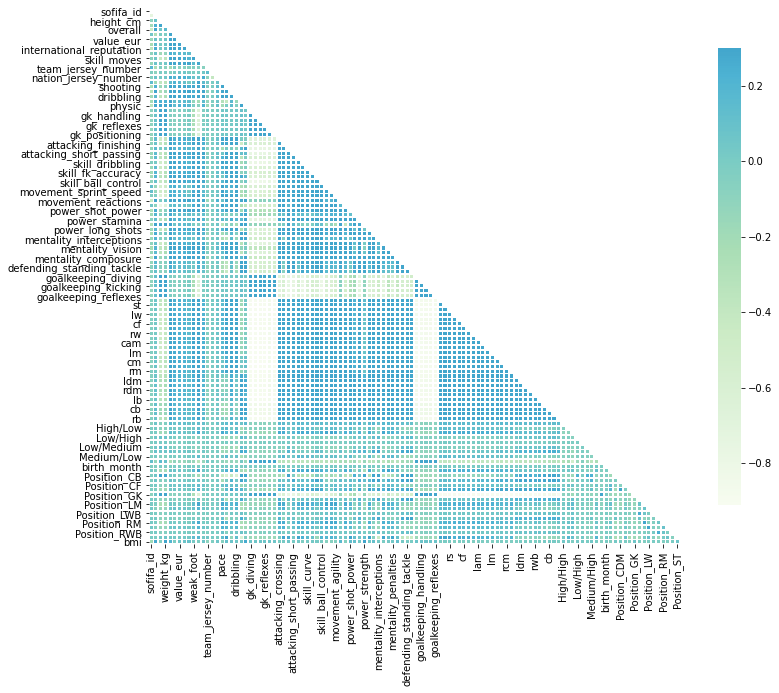

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,12))

# Compute the correlation matrix
corr = sample.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="GnBu", vmax=.3, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .7})

From the above correlation chart, we can see a lot of Goalkeepers attributes have a strong negative correlation with the attributes possessed by a Forward, Midfielder and Defender. Players with more attacking role have higher dribbling, passing and shooting skills.

Let's scale our features

In [29]:
scaled = StandardScaler()
X = scaled.fit_transform(sample)
recommendations = NearestNeighbors(n_neighbors=6,algorithm='kd_tree')
recommendations.fit(X)
player_index = recommendations.kneighbors(X)[1]

# Define a function to get Player's Index
def get_index(x):
    return df_20[df_20['short_name']==x].index.tolist()[0]



In [30]:
# Fetch 5 indexes of similar players
def recommend_similar(player):
    print("These are 5 players similar to {} : ".format(player))
    index=  get_index(player)
    for i in player_index[index][1:]:
        print("Name: {}\nOverall: {}\nMarket Value: €{}\nAge: {}\nBMI: {:.2f}\n".format(df_20.iloc[i]['short_name'],df_20.iloc[i]['overall'], df_20.iloc[i]['value_eur'], df_20.iloc[i]['age'], df_20.iloc[i]['bmi']))

In [31]:
recommend_similar('P. Dybala')

These are 5 players similar to P. Dybala : 
Name: M. Salah
Overall: 90
Market Value: €80500000
Age: 27
BMI: 23.18

Name: R. Sterling
Overall: 88
Market Value: €73000000
Age: 24
BMI: 23.88

Name: Bernardo Silva
Overall: 87
Market Value: €64000000
Age: 24
BMI: 21.38

Name: L. Sané
Overall: 86
Market Value: €61000000
Age: 23
BMI: 22.40

Name: C. Eriksen
Overall: 88
Market Value: €68000000
Age: 27
BMI: 23.20



Now, let's change the problem and seek similar clubs (teams).
To do so, we will evaluate the clubs by the median among all players belonging to the club in different aspects of the game. There are other alternatives to compare the club, and you are invited to implement your own ideas.

In [36]:
sample = df_20.sort_values(by=['overall'], ascending=False)
new_sample = pd.DataFrame(columns = ["overall", "pace", "shooting", "passing", "dribbling", "defending", "physic", "team"])
for club in sample['club'].unique():
    overall = sample[sample['club']==club]['overall'].median()
    pace = sample[sample['club']==club]['pace'].median()
    shooting = sample[sample['club']==club]['shooting'].median()
    passing = sample[sample['club']==club]['passing'].median()
    dribbling = sample[sample['club']==club]['dribbling'].median()
    defending = sample[sample['club']==club]['defending'].median()
    physic = sample[sample['club']==club]['physic'].median()
    team = club
    data = [overall, pace, shooting, passing, dribbling, defending, physic, team]
    df_length = len(new_sample)
    new_sample.loc[df_length] = data

In [35]:
new_sample.head()

,overall,pace,shooting,passing,dribbling,defending,physic,team
0,82.0,69.0,62.0,69.0,74.0,65.0,67.0,FC Barcelona
1,83.0,69.0,65.0,71.0,75.0,66.0,71.0,Juventus
2,79.0,74.0,54.0,70.0,75.0,61.0,66.0,Paris Saint-Germain
3,80.0,70.0,60.0,64.0,71.0,59.0,72.0,Atlético Madrid
4,82.0,77.0,68.0,71.0,78.0,59.0,67.0,Real Madrid


In [37]:
# Let's scale this and re-run the kNN. This time using the club data.
scaled = StandardScaler()
X = scaled.fit_transform(new_sample.iloc[:,0:7])
recommendations = NearestNeighbors(n_neighbors=4,algorithm='kd_tree')
recommendations.fit(X)
club_index = recommendations.kneighbors(X)[1]

In [38]:
def get_index(x):
    return new_sample[new_sample['team']==x].index.tolist()[0]

# Fetch 5 indexes of similar players
def recommend_similar(club):
    print("These are 3 clubs similar to {} : ".format(club))
    index=  get_index(club)
    for i in club_index[index][1:]:
        print("Name: {}\nOverall: {}\nPace: {}\nShooting: {}\nPassing: {}\nDribbling: {}\nDefending: {}\n".format(new_sample.iloc[i]['team'],new_sample.iloc[i]['overall'],new_sample.iloc[i]['pace'],new_sample.iloc[i]['shooting'],new_sample.iloc[i]['passing'],new_sample.iloc[i]['dribbling'],new_sample.iloc[i]['defending']))

In [43]:
recommend_similar('Roma')

These are 3 clubs similar to Roma : 
Name: Ajax
Overall: 75.5
Pace: 69.5
Shooting: 62.0
Passing: 66.5
Dribbling: 72.0
Defending: 58.5

Name: Leicester City
Overall: 75.0
Pace: 69.0
Shooting: 62.0
Passing: 66.0
Dribbling: 72.0
Defending: 61.0

Name: Napoli
Overall: 78.0
Pace: 71.0
Shooting: 63.0
Passing: 69.0
Dribbling: 74.0
Defending: 56.0



In [44]:
recommend_similar('Juventus')

These are 3 clubs similar to Juventus : 
Name: Chelsea
Overall: 79.0
Pace: 70.0
Shooting: 64.0
Passing: 69.0
Dribbling: 75.0
Defending: 62.0

Name: FC Barcelona
Overall: 82.0
Pace: 69.0
Shooting: 62.0
Passing: 69.0
Dribbling: 74.0
Defending: 65.0

Name: Milan
Overall: 79.0
Pace: 72.0
Shooting: 63.0
Passing: 67.0
Dribbling: 74.0
Defending: 65.0

